In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.ioff()
from skimage import io
from skimage.draw import disk, circle_perimeter
import pandas as pd
import numpy as np
from os import path

In [2]:
base_path = "/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/"
res_dir_path = base_path + "alignment_result/"
dir_path = res_dir_path + "aligned_despeckle/"
cell_data_fn_template = "m{}r{}_{}_output.txt"
img_fn_template = "m{}r{}_{}.tif"

In [3]:
xcolname = "Intensity center X (px) (ch 0)"
ycolname = "Intensity center Y (px) (ch 0)"
zcolname = "Intensity center Z (px) (ch 0)"

In [4]:
roi_diameter = [8,7,4]
xy_scale = 1.19;
z_scale = 2;
tolerance = 4

In [5]:
landmark_first_mice = [1, 3, 4, 6,7,9,12,15,17, 18]
landmark_first_mice = []
ctx_first_mice = [2,5,8,10,11,13,14,16,19,20]
ctx_first_mice = [5,10,11]
ctx_session_order = ["ctx", "landmark1", "landmark2"]
landmark_session_order = ["landmark", "ctx1", "ctx2"]

max_region_no = 4

In [6]:
def calculate_intensity(center_x, center_y, center_z, img):
    center_x = int(round(center_x))
    center_y = int(round(center_y))
    center_z = int(round(center_z))
    sum_int = 0
    area_int = 0
    for i in range(-2,3):
        if(center_z+i >= 0 and center_z+i < img.shape[0]):
            diameter = roi_diameter[abs(i)]
            rad = diameter//2
            disk_ = disk((center_y, center_x), rad, shape=img[0].shape)
            sum_int += np.sum(img[center_z+i][disk_])
            area_int += len(img[center_z+i][disk_])
    if area_int == 0:
        print(center_x, center_y, center_z)
        return 0
    return sum_int/area_int

In [7]:
def update_intensity_for_df(df, img):
    df["intensity_standarized"] = df.apply(lambda row : calculate_intensity(row[xcolname],
                     row[ycolname], row[zcolname], img), axis = 1)
    return df[df['Mean Intensity (ch 0)']/df['intensity_standarized']<=1.5]

In [8]:
def rescale_df(df):
    df[xcolname] = df[xcolname]*xy_scale
    df[ycolname] = df[ycolname]*xy_scale
    df[zcolname] = df[zcolname]*z_scale
    return df

In [9]:
def calculate_overlap(df1, df2):
    res_df = pd.DataFrame(columns=["idx1", "idx2", "intensity1", "intensity2"])
    multiple_algs = 0
    for idx1, row1 in df1.iterrows():
        rep_counter = 0
        for idx2, row2 in df2.iterrows():
            dist = np.linalg.norm(row1[xcolname:zcolname]-row2[xcolname:zcolname])
            if dist < tolerance:
                rep_counter += 1
                if rep_counter == 2:
                    multiple_algs+=1
                elif rep_counter == 1:
                    res_df = res_df.append({"idx1":idx1, "idx2" :idx2, 
                                            "intensity1":row1['intensity_standarized'], 
                                            "intensity2":row2['intensity_standarized']},
                                           ignore_index=True)
    return res_df

In [10]:
def find_fluorescence_profile(row, bgrs):
    row_i0 = row.i0 - bgrs[0]
    row_i1 = row.i1 - bgrs[1]
    row_i2 = row.i2 - bgrs[2]
#     if row_i0 > row_i1 and row_i1 > row_i2:
#         return 'a0'
#     elif row_i0 > row_i2 and row_i2 > row_i1:
#         return 'a1'
#     elif row_i1 > row_i0 and row_i0 > row_i2:
#         return 'b0'
#     elif row_i1 > row_i2 and row_i2 > row_i0:
#         return 'b1'
#     elif row_i2 > row_i0 and row_i0 > row_i1:
#         return 'c0'
#     elif row_i2 > row_i1 and row_i1 > row_i0:
#         return 'c1'
#     return 'd'
    if row_i0 > row_i1 and row_i0 > row_i2:
        return 'a'
    elif row_i1 > row_i0 and row_i1 > row_i2:
        return 'b'
    elif row_i2 > row_i0 and row_i2 >row_i1:
        return 'c'
    else:
        return 'd'

In [51]:
def find_persistent_cells(mouse, region, rdf1, rdf2, bgrs):
    persistent = rdf1.join(rdf2.set_index("idx1"), on="idx1", how="inner", rsuffix="_r")
    ordered = pd.DataFrame(columns=["i0", "i1", "i2"])
    ordered.i0 = persistent.intensity2
    ordered.i1 = persistent.intensity1
    ordered.i2 = persistent.intensity2_r
    ordered["fluo_type"] = ordered.apply(lambda row 
                                         : find_fluorescence_profile(row, bgrs), axis = 1)
    ordered.to_csv(dir_path + cell_data_fn_template.format(mouse, region, "ordered"))

In [12]:
def find_background_intensities(df_array):
    res = np.array([])
    for i in range(len(df_array)):
        df = df_array[i]
        background_cells = df[df.intensity_standarized<df.intensity_standarized.quantile(0.25)]
        #res=np.append(res, background_cells.describe().intensity_standarized['mean'])
        res=np.append(res, df.intensity_standarized.quantile(0.25))    
    return res

In [3]:
import numpy as np
tst = np.array([[1,4],[2,5],[3,2]])

In [5]:
tst.shape[0]

3

In [13]:
def get_bgrs(df):
    ret = np.zeros(3)
    ret[0] = df[df.i0<df.i0.quantile(0.25)].describe().i0['mean']
    ret[1] = df[df.i1<df.i1.quantile(0.25)].describe().i1['mean']
    ret[2] = df[df.i2<df.i2.quantile(0.25)].describe().i2['mean']
    
    return [df.i0.quantile(0.25), df.i1.quantile(0.25), df.i2.quantile(0.25)]

In [14]:
def compare_sessions(mouse, region, session_order_code):
    df_array={}
    img_array={}
    session_order = sessions[session_order_code]
    for i in range(len(session_order)):
        df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                  .format(mouse, region, session_order[i]), "\t", header=1)
        img_array[i] =  io.imread(dir_path + img_fn_template
                                  .format(mouse, region, session_order[i])).astype("uint8")
        
    for i in range(len(session_order)):
        df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
        df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
        df_array[i] = rescale_df( df_array[i])
        
    bgrs = find_background_intensities(df_array)
    #tutaj b wazna kolejnosc!!!   
    rdf1 = calculate_overlap(df_array[1], df_array[0])  
    rdf1.to_csv(dir_path + cell_data_fn_template
                .format(mouse, region, session_order[1]+"_"+session_order[0]))
    rdf2 = calculate_overlap(df_array[1], df_array[2])
    rdf2.to_csv(dir_path + cell_data_fn_template
                .format(mouse, region, session_order[1]+"_"+session_order[2]))
    find_persistent_cells(mouse, region, rdf1, rdf2, bgrs)
    return rdf1, rdf2


In [56]:
def get_btw_session_overlap(mouse, region, session_order_code, s1_id, s2_id):
    df_array={}
    img_array={}
    session_order = sessions[session_order_code]
    for i in range(len(session_order)):
        df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                  .format(mouse, region, session_order[i]), "\t", header=1)
        img =  io.imread(dir_path + img_fn_template
                                  .format(mouse, region, session_order[i])).astype("uint8")
        df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
        df_array[i] = update_intensity_for_df(df_array[i], img)
        
    bgrs = find_background_intensities(df_array)
    #tutaj b wazna kolejnosc!!!   
    rdf = calculate_overlap(df_array[s1_id], df_array[s2_id])  
    rdf.to_csv(dir_path + cell_data_fn_template
                .format(mouse, region, session_order[s1_id]+"_"+session_order[s2_id]))
    return rdf

In [48]:
def compare_sessions_from_files(mouse, region, session_order_code):
    df_array={}
    session_order = sessions[session_order_code]
    for i in range(len(session_order)):
        df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                  .format(mouse, region, session_order[i]), "\t", header=1)
        img =  io.imread(dir_path + img_fn_template
                                  .format(mouse, region, session_order[i])).astype("uint8")
        df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
        df_array[i] = update_intensity_for_df(df_array[i], img)
        df_array[i] = rescale_df( df_array[i])
        
    bgrs = find_background_intensities(df_array)
    #tutaj b wazna kolejnosc!!!   
    rdf1 = pd.read_csv(dir_path + cell_data_fn_template
                .format(mouse, region, session_order[1]+"_"+session_order[0]))
    rdf2 = pd.read_csv(dir_path + cell_data_fn_template
                .format(mouse, region, session_order[1]+"_"+session_order[2]))
    find_persistent_cells(mouse, region, rdf1, rdf2, bgrs)
    return rdf1, rdf2


In [58]:
sessions={
'l' : ["landmark", "ctx1", "ctx2"],
'c' : ["ctx", "landmark1", "landmark2"]}

processing_queue = [(1,1,'l',0,2), (1,2,'l',0,2), 
                    (2,1,'c',0,2), (2,2,'c',0,2), 
                    (3,1,'l',0,2), (3,2,'l',0,2), 
                    (4,1,'l',0,2), (4,2,'l',0,2), 
                    (5,1,'c',0,2), (5,2,'c',0,2), (5,3,'c',0,2), 
                    (6,1,'l',0,2), (6,2,'l',0,2), 
                    (7,1,'l',0,2), (7,2,'l',0,2), (7,3,'l',0,2), 
                    (8,1,'c',0,2), (8,2,'c',0,2), 
                    (9,1,'l',0,2), (9,2,'l',0,2),
                   (10,1,'c',0,2), (10,2,'c',0,2), (10,3,'c',0,2), 
                    (11,1,'c',0,2), (11,2,'c',0,2), (11,3,'c',0,2), 
                    (12,1,'l',0,2), (12,2,'l',0,2), (12,3,'l',0,2),
                   (13,1,'c',0,2), (13,2,'c',0,2), (13,3,'c',0,2),
                   (14,1,'c',0,2), (14,2,'c',0,2), (14,3,'c',0,2), (14,4,'c',0,2),
                   (15,1,'l',0,2), (15,2,'l',0,2), (15,3,'l',0,2),
                   (16,1,'c',0,2), (16,2,'c',0,2),
                   (17,1,'l',0,2), (17,2,'l',0,2),
                   (18,1,'l',0,2), (18,2,'l',0,2),
                   (19,1,'c',0,2), (19,2,'c',0,2),
                   (20,1,'c',0,2), (20,2,'c',0,2)]

from multiprocessing import Pool

with Pool(8) as p:
    p.starmap(get_btw_session_overlap, processing_queue)

KeyboardInterrupt: 

In [61]:
processing_queue = [(20,3,'c',0,2)]

from multiprocessing import Pool

with Pool(8) as p:
    p.starmap(get_btw_session_overlap, processing_queue)

In [ ]:
get_btw_session_overlap(mouse, region, session_order_code, s1_id, s2_id)

In [60]:
processing_queue = [(2,2,'c'), (5,3,'c'), (8,1,'c'), (8,2,'c'), (9,2,'l'),(10,3,'c'), 
                    (11,3,'c'), (12,1,'l'), (12,3,'l'), (13,3,'c'), (14,1, 'c'),
                   (14,2, 'c'), (14,3, 'c'), (14,4, 'c'), (15,1, 'l'), (15,2, 'l'), (15,3, 'l'),
                    (16,1,'c'),(16,2,'c'),(18,1,'l'),(18,2,'l'),(19,1,'c'),(20,1,'c'),(20,3,'c'),
                    (12,2,'l')]
proc_queue = [(7,1,'l'), (7,2,'l'), (7,3,'l')]
from multiprocessing import Pool

with Pool(8) as p:
    p.starmap(compare_sessions, proc_queue)


In [47]:
mouse

11

In [20]:
ftypes = ['a', 'b', 'c']


In [21]:
cll_pairs = [(2,1), (5,1), (5,2), (10,1), (10,2), (11,1), (11,2), (19,2), (19,3), (13,2), (13,1)]
#cll_pairs = [(5,1), (5,2), (10,1), (10,2), (11,1), (11,2)]
lcc_pairs = [(1,1), (1,2), (3,1), (3,2), (9,1), (17,1), (17,2)]
lcc_pairs = [(1,1), (1,2), (3,1), (3,2), (17,1), (17,2)]

In [22]:
bgrs = pd.read_csv("/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/trans_tst/bgrs.csv")

1 1
1 2
3 1
3 2
17 1
17 2


<IPython.core.display.Javascript object>


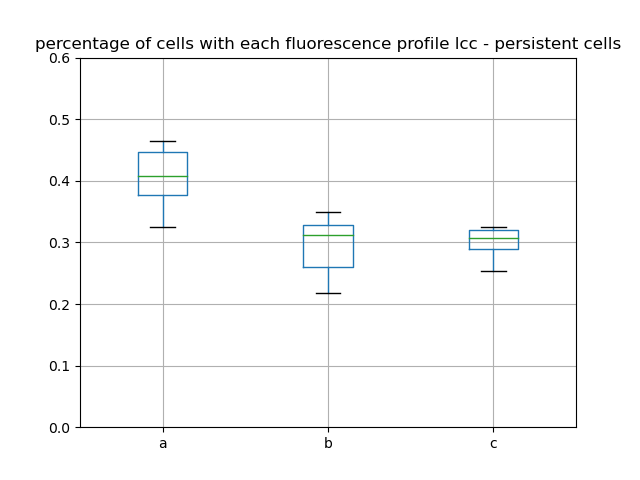

In [23]:
fluotype_count = pd.DataFrame(columns = ftypes)
agg_df = pd.DataFrame()
for mouse, region in lcc_pairs:
    print(mouse, region)
    res = np.array([])
    df = pd.read_csv(dir_path + cell_data_fn_template.format(mouse, region, "ordered"))
    bgrs_ = get_bgrs(df)
    df["fluo_type"] = df.apply(lambda row : find_fluorescence_profile(row, bgrs_), axis = 1)
       
    df.i0 = df.i0 - bgrs_[0]
    df.i1 = df.i1 - bgrs_[1]
    df.i2 = df.i2 - bgrs_[2]
        
        
        
    df['sd1'] = abs(df.i2 - df.i0)
    df['sd2'] = abs(df.i1 - df.i0)
    df['ss'] = abs(df.i2 - df.i1)
        
    grouped = df.groupby('fluo_type').agg({'i0':'mean', 'i1':'mean','i2':'mean',
                                           'sd1': 'mean', 'sd2': 'mean', 'ss': 'mean',
                                           'fluo_type' :'count'})
    for ftype in ftypes:
        if not grouped[grouped.index==ftype].empty:
            res= np.append(res, int(grouped[grouped.index==ftype].fluo_type)/df.shape[0])
        else:
            res= np.append(res,0)
            print(ftype)
    fluotype_count = fluotype_count.append(pd.DataFrame(res.reshape(1,-1), columns=ftypes))
    agg_df = agg_df.append(df)
grouped_agg = agg_df.groupby('fluo_type').agg({'i0':'mean', 'i1':'mean','i2':'mean',
                                               'sd1': 'mean', 'sd2': 'mean', 'ss': 'mean',
                                               'fluo_type' :'count'})

fluotype_count.boxplot(column=ftypes)
plt.title("percentage of cells with each fluorescence profile lcc - persistent cells")
plt.ylim(0, 0.6)
plt.show()


In [ ]:
fluotype_count

In [26]:
fluotype_count

,a,b,c
0,0.375000,0.327869,0.297131
0,0.431589,0.247934,0.320478
0,0.465162,0.217861,0.316977
0,0.450867,0.296243,0.252890
0,0.385353,0.326940,0.287707
0,0.324886,0.349578,0.325536


In [27]:
fluotype_count = pd.DataFrame(columns = ftypes)
for mouse in ctx_first_mice:
    for region in [1,2]:
        res = np.array([])
        bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
        df = pd.read_csv(dir_path + cell_data_fn_template.format(mouse, region, "ordered"))
        bgrs_ = [float(bgr.i0), float(bgr.i1), float(bgr.i2)]
        df["fluo_type"] = df.apply(lambda row : find_fluorescence_profile(row, bgrs_), axis = 1)
        grouped = df.groupby('fluo_type').agg({'i0':'mean', 'i1':'mean','i2':'mean',
                                               'sd1': 'mean', 'sd2': 'mean', 'ss': 'mean',
                                               'fluo_type' :'count'})
        for ftype in ftypes:
            res= np.append(res, int(grouped[grouped.index==ftype].i0)/df.shape[0])
        fluotype_count = fluotype_count.append(pd.DataFrame(res.reshape(1,-1), columns=ftypes))
        
fluotype_count.boxplot(column=ftypes)
plt.ylim(0,1)
plt.title("percentage of cells with each fluorescence profile cll")
plt.show()

<ipython-input-27-a16020dab489>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]


SpecificationError: Column(s) ['sd1', 'sd2', 'ss'] do not exist

In [29]:
for mouse in ctx_first_mice:
    for region in [1,2]:
        bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
        res = np.array([])
        df = pd.read_csv(dir_path + cell_data_fn_template.format(mouse, region, "ordered"))
        bgrs_ = [float(bgr.i0), float(bgr.i1), float(bgr.i2)]
        df["fluo_type"] = df.apply(lambda row : find_fluorescence_profile(row, bgrs_), axis = 1)

<ipython-input-29-b4c46fcab77e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
<ipython-input-29-b4c46fcab77e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
<ipython-input-29-b4c46fcab77e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
<ipython-input-29-b4c46fcab77e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
<ipython-input-29-b4c46fcab77e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
<ipython-input-29-b4c46fcab77e>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]


In [30]:
res = {}
for ftype in ftypes:
    res[ftype] = np.array([])

(1487, 5)
(876, 5)
(1260, 5)
(1382, 5)
(1082, 5)
(650, 5)
(1013, 7)


<ipython-input-31-ad9cd0f8ec23>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
<ipython-input-31-ad9cd0f8ec23>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
<ipython-input-31-ad9cd0f8ec23>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
<ipython-input-31-ad9cd0f8ec23>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
<ipython-input-31-ad9cd0f8ec23>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
<ipython-input-31-ad9cd0f8ec23>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]


<IPython.core.display.Javascript object>


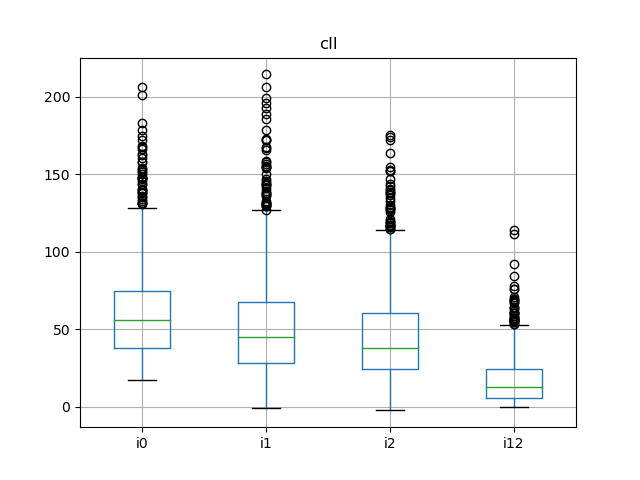

NameError: name 'ttest_ind' is not defined

In [31]:
intensity_count = pd.DataFrame()
for mouse in ctx_first_mice:
    for region in [1,2]:
        bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
        df = pd.read_csv(dir_path + cell_data_fn_template.format(mouse, region, "ordered"))
        print(df.shape)
        #df = df[df.i1>df.i1.quantile(0.95)]
        bgrs_ = [float(bgr.i0), float(bgr.i1), float(bgr.i2)]
        df[['i0', 'i1', 'i2']] = df[['i0', 'i1', 'i2']]-bgrs_
        df['i01'] = df.i0 - df.i1
        df['i12'] = abs(df.i1 - df.i2)
        df = df[df.i0>df.i0.quantile(0.85)]
        intensity_count = intensity_count.append(df)
print(intensity_count.shape)      
intensity_count.boxplot(['i0','i1', 'i2', 'i12'])
#plt.ylim(-10,255)
plt.title("cll")
plt.show()
ttest_ind(intensity_count.i0, intensity_count.i1, equal_var = False)

In [32]:
intensity_count = pd.DataFrame()
for mouse in landmark_first_mice:
    for region in [1,2]:
        bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
        df = pd.read_csv(dir_path + cell_data_fn_template.format(mouse, region, "ordered"))
        print(df.shape)
        #df = df[df.i0>df.i0.quantile(0.95)]
        bgrs_ = [float(bgr.i0), float(bgr.i1), float(bgr.i2)]
        df[['i0', 'i1', 'i2']] = df[['i0', 'i1', 'i2']]-bgrs_
        df['i01'] = df.i0 - df.i1
        df['i12'] = df.i1 - df.i2
        
        df = df[df.i2>df.i2.quantile(0.85)]
        intensity_count = intensity_count.append(df)
intensity_count.boxplot(['i01', 'i12'])
plt.title("lcC")
plt.show()
ttest_ind(intensity_count.i0, intensity_count.i1, equal_var = True)

KeyError: "None of [Index(['i01', 'i12'], dtype='object')] are in the [columns]"

In [33]:
intensity_count = pd.DataFrame()
for mouse in landmark_first_mice:
    for region in [1,2]:
        bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
        df = pd.read_csv(dir_path + cell_data_fn_template.format(mouse, region, "ordered"))
        print(df.shape)
        #df = df[df.i1>df.i1.quantile(0.95)]
        bgrs_ = [float(bgr.i0), float(bgr.i1), float(bgr.i2)]
        df[['i0', 'i1', 'i2']] = df[['i0', 'i1', 'i2']]-bgrs_
        df['i01'] = df.i0 - df.i1
        df['i12'] = abs(df.i1 - df.i2)
        intensity_count = intensity_count.append(df)
intensity_count.describe()


ValueError: Cannot describe a DataFrame without columns

In [34]:
session_order = ctx_session_order
overlaps_df = pd.DataFrame(columns=["ctx l", "l l", "avg_int_cl", "avg_int_ll"])
for mouse in ctx_first_mice:
    for region in [1,2]:
        res = np.zeros(4)
        rdf1 = pd.read_csv(dir_path + cell_data_fn_template
                    .format(mouse, region, session_order[1]+"_"+session_order[0]))
        
        rdf2 = pd.read_csv(dir_path + cell_data_fn_template
                    .format(mouse, region, session_order[1]+"_"+session_order[2]))
        

In [35]:
overlaps_df.boxplot(["ctx l", "l l", "avg_int_cl", "avg_int_ll"])
plt.show()

KeyError: "None of [Index(['ctx l', 'l l', 'avg_int_cl', 'avg_int_ll'], dtype='object')] are in the [columns]"

In [36]:
session_order = landmark_session_order
rdf_cum1 = pd.DataFrame()
rdf_cum2 = pd.DataFrame()
for mouse in landmark_first_mice:
    for region in [1,2]:
        bgr = bgrs[bgrs.mouse==mouse][bgrs.region==region]
        bgrs_ = [float(bgr.i0), float(bgr.i1), float(bgr.i2)]
        rdf1 = pd.read_csv(dir_path + cell_data_fn_template
                    .format(mouse, region, session_order[1]+"_"+session_order[0]))    
        rdf2 = pd.read_csv(dir_path + cell_data_fn_template
                    .format(mouse, region, session_order[1]+"_"+session_order[2]))
        rdf1['intensity_dif'] = rdf1.intensity2 - rdf1.intensity1 - bgrs_[0] + bgrs_[1]
        rdf2['intensity_dif'] = rdf2.intensity1 - rdf2.intensity2 - bgrs_[1] + bgrs_[2]
        rdf_cum1 = rdf_cum1.append(rdf1)
        rdf_cum2 = rdf_cum2.append(rdf2)

In [37]:
plt.hist(rdf_cum1[rdf_cum1.intensity2 > rdf_cum1.intensity2.quantile(0.75)].intensity2, 50)
plt.show()
plt.hist(rdf_cum1[rdf_cum1.intensity1 > rdf_cum1.intensity1.quantile(0.75)].intensity1, 50)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'intensity2'

In [38]:
top_landmark = rdf_cum1[rdf_cum1.intensity2>rdf_cum1.intensity2.quantile(0.9)]
top_landmark = top_landmark[top_landmark.intensity_dif>0]
top_ctx = rdf_cum1[rdf_cum1.intensity1>rdf_cum1.intensity1.quantile(0.9)]
top_ctx = top_ctx[top_ctx.intensity_dif<0]

top_ctx1 = rdf_cum2[rdf_cum2.intensity1>rdf_cum2.intensity1.quantile(0.9)]
top_ctx1 = top_ctx1[top_ctx1.intensity_dif>0]
top_ctx2 = rdf_cum2[rdf_cum2.intensity2>rdf_cum2.intensity2.quantile(0.9)]
top_ctx2 = top_ctx2[top_ctx2.intensity_dif<0]

plt.bar(['lc_l', 'lc_c', 'cc_c1', 'cc_c2'],
    [np.mean(top_landmark.intensity_dif), abs(np.mean(top_ctx.intensity_dif)), 
     np.mean(top_ctx1.intensity_dif), abs(np.mean(top_ctx2.intensity_dif))])
plt.title('df between consecutive sessions lcc')
plt.ylim(-20,50)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'intensity2'

In [39]:
session_order = landmark_session_order

s12 = pd.DataFrame()
s23 = pd.DataFrame()
s21 = pd.DataFrame()
s32 = pd.DataFrame()

for mouse, region in lcc_pairs:
        df_array={}
        img_array={}
        for i in range(len(session_order)):
            df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                      .format(mouse, region, session_order[i]), "\t", header=1)
            img_array[i] =  io.imread(dir_path + img_fn_template
                                      .format(mouse, region, session_order[i])).astype("uint8")
        for i in range(len(session_order)):
            df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
            df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
        rdf1 = pd.read_csv(dir_path + cell_data_fn_template
                           .format(mouse, region, session_order[1]+"_"+session_order[0]))    
        rdf2 = pd.read_csv(dir_path + cell_data_fn_template
                           .format(mouse, region, session_order[1]+"_"+session_order[2]))
        df_arr = df_array[0][['intensity_standarized']]
        df_arr = df_arr.join(rdf1.set_index("idx2"), rsuffix="_rdf")
        df_arr[["intensity1"]] = df_arr[["intensity1"]].fillna(0)
        s12 = s12.append(df_arr)
        df_arr2 = df_array[1][['intensity_standarized']]
        df_arr2 = df_arr2.join(rdf2.set_index("idx1"), rsuffix="_rdf")
        df_arr2[["intensity2"]] = df_arr2[["intensity2"]].fillna(0)
        s23 = s23.append(df_arr2)
        df_arr3 = df_array[1][['intensity_standarized']]
        df_arr3 = df_arr3.join(rdf1.set_index("idx1"), rsuffix="_rdf")
        df_arr3[["intensity2"]] = df_arr3[["intensity2"]].fillna(0)
        s21 = s21.append(df_arr3)
        
        df_arr4 = df_array[2][['intensity_standarized']]
        df_arr4 = df_arr4.join(rdf2.set_index("idx2"), rsuffix="_rdf")
        df_arr4[["intensity1"]] = df_arr3[["intensity1"]].fillna(0)
        s32 = s32.append(df_arr4)
        

<IPython.core.display.Javascript object>


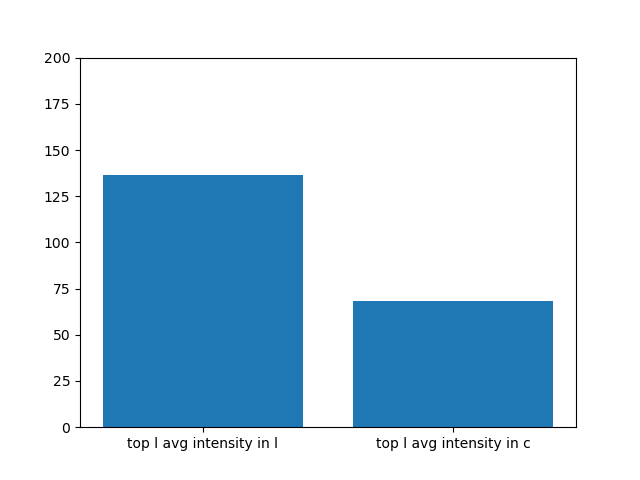

In [40]:
tmp = s12[s12.intensity_standarized>s12.intensity_standarized.quantile(0.95)]
plt.bar(['top l avg intensity in l', 'top l avg intensity in c'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity1)])
plt.ylim(0,200)
plt.show()

<IPython.core.display.Javascript object>


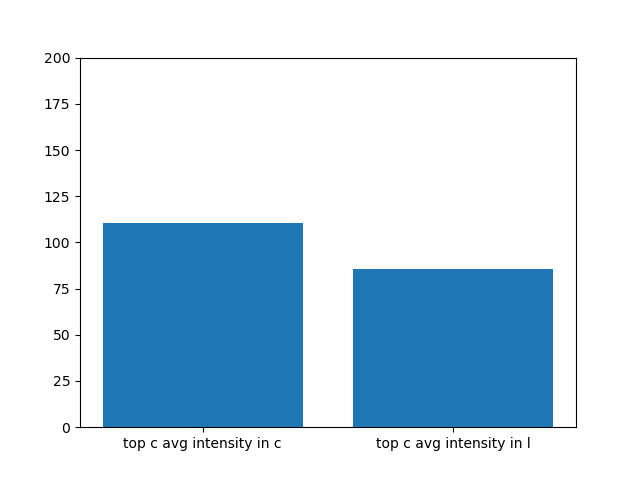

In [41]:
tmp = s21[s21.intensity_standarized>s21.intensity_standarized.quantile(0.95)]
plt.bar(['top c avg intensity in c', 'top c avg intensity in l'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])
plt.ylim(0,200)
plt.show()

<IPython.core.display.Javascript object>


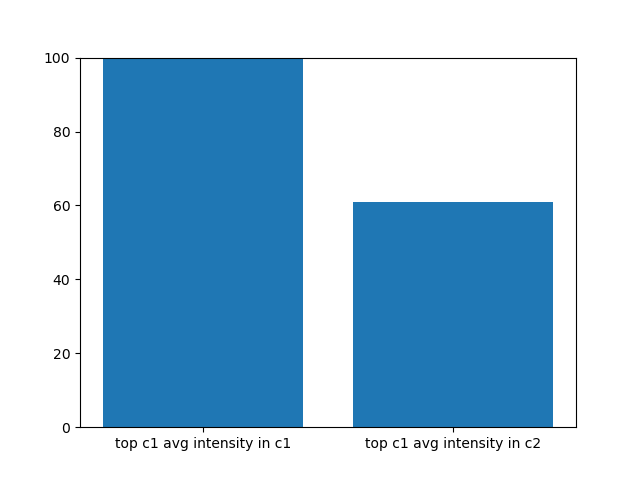

In [42]:
tmp = s23[s23.intensity_standarized>s23.intensity_standarized.quantile(0.95)]
plt.bar(['top c1 avg intensity in c1', 'top c1 avg intensity in c2'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])
plt.ylim(0,100)
plt.show()

<IPython.core.display.Javascript object>


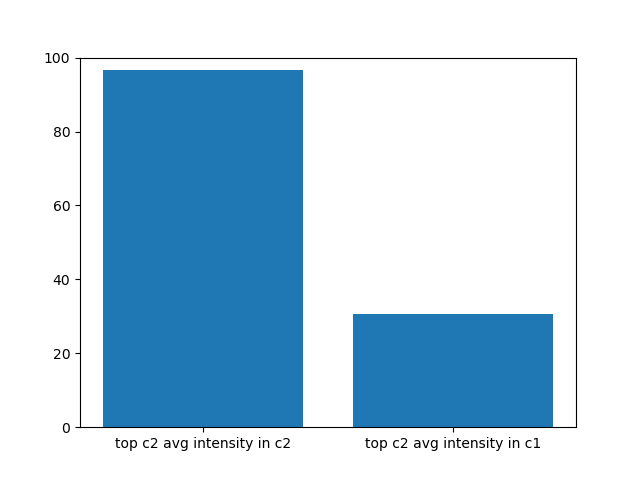

In [43]:
tmp = s32[s32.intensity_standarized>s32.intensity_standarized.quantile(0.95)]
plt.bar(['top c2 avg intensity in c2', 'top c2 avg intensity in c1'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity1)])
plt.ylim(0,100)
plt.show()

In [44]:
session_order = ctx_session_order

s12 = pd.DataFrame()
s23 = pd.DataFrame()
s21 = pd.DataFrame()
s32 = pd.DataFrame()

for mouse in ctx_first_mice:
    for region in [1,2]:
        df_array={}
        img_array={}
        for i in range(len(session_order)):
            df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                      .format(mouse, region, session_order[i]), "\t", header=1)
            img_array[i] =  io.imread(dir_path + img_fn_template
                                      .format(mouse, region, session_order[i])).astype("uint8")
        for i in range(len(session_order)):
            df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
            df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
        rdf1 = pd.read_csv(dir_path + cell_data_fn_template
                           .format(mouse, region, session_order[1]+"_"+session_order[0]))    
        rdf2 = pd.read_csv(dir_path + cell_data_fn_template
                           .format(mouse, region, session_order[1]+"_"+session_order[2]))
        df_arr = df_array[0][['intensity_standarized']]
        df_arr = df_arr.join(rdf1.set_index("idx2"), rsuffix="_rdf")
        df_arr[["intensity1"]] = df_arr[["intensity1"]].fillna(0)
        s12 = s12.append(df_arr)
        df_arr2 = df_array[1][['intensity_standarized']]
        df_arr2 = df_arr2.join(rdf2.set_index("idx1"), rsuffix="_rdf")
        df_arr2[["intensity2"]] = df_arr2[["intensity2"]].fillna(0)
        s23 = s23.append(df_arr2)
        df_arr3 = df_array[1][['intensity_standarized']]
        df_arr3 = df_arr3.join(rdf1.set_index("idx1"), rsuffix="_rdf")
        df_arr3[["intensity2"]] = df_arr3[["intensity2"]].fillna(0)
        s21 = s21.append(df_arr3)
        
        df_arr4 = df_array[2][['intensity_standarized']]
        df_arr4 = df_arr4.join(rdf2.set_index("idx2"), rsuffix="_rdf")
        df_arr4[["intensity1"]] = df_arr3[["intensity1"]].fillna(0)
        s32 = s32.append(df_arr4)
        
        

In [45]:
s21.shape

(12228, 5)

In [46]:
s23.shape

(12228, 5)

In [ ]:
tmp = s12[s12.intensity_standarized>s12.intensity_standarized.quantile(0.95)]
plt.bar(['top c avg intensity in c', 'top c avg intensity in l'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity1)])
plt.ylim(0,100)
plt.show()

In [ ]:
tmp = s21[s21.intensity_standarized>s21.intensity_standarized.quantile(0.95)]
print(tmp.shape)
plt.bar(['top l avg intensity in l', 'top l avg intensity in c'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])
print(np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2))
plt.ylim(0,100)
plt.show()